## Sample Data from some function

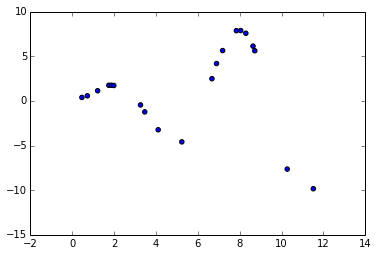

In [252]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from sklearn import gaussian_process
from functools import partial

# Define the function which you wish to estimate, adding noise
def func(x):
    return x*np.sin(x)
def noise(x):
    return np.random.randn(len(x)) * 0.1
# Sample random values from [0, 2 * pi) and plot them
x_obs = np.sort(np.random.random_sample([20]) * 4 * np.pi)
y_obs = np.asarray([func(x) for x in x_obs]) + noise(x_obs)
plt.scatter(x_obs,y_obs)
plt.show()

A **Gaussian process** is a collection of random variables, any finite number of which have a joint Gaussian distribution. Below we outline a GP given some data and predict new values and the variance, this is assuming we know the parameters GP and kernel function. You can experiment with these parameters but we do not include an optimiser.

## Polynomail basis function kernel

In [253]:
def polynomial(x_1, x_2, sigma_f=2, l=1, deg=1):
    k = np.empty((len(x_1), len(x_2)))
    scale = 2 * (l ** 2)
    for i in range(len(x_1)):
        for j in range(len(x_2)):
            val = 0
            for d in range(deg):
                val += (x_1[i] * x_2[j]) ** (d + 1)
            k[i][j] = val / scale
    return k

## Squared Exponential kernel function

In [254]:
# Some helper functions we will use later
def squared_exponential(x_1, x_2, sigma_f=2, l=1):
    k = np.empty((len(x_1), len(x_2)))
    scale = 2 * (l ** 2)
    for i in range(len(x_1)):
        for j in range(len(x_2)):
            k[i][j] = sigma_f * np.exp(-(x_1[i] - x_2[j]) ** 2 / scale)
    return k

In [255]:
# A wrapper to make it easier to change covariance function
def get_cov_matrix(cov, x, y, sigma_f, l):
    return cov(x, y, sigma_f, l)

def mean_of_gp(k_mat, k_s, k_ss, y, new):
    temp = np.dot(k_s, linalg.inv(k_mat))
    return np.dot(temp, y)

def var_of_gp(k_mat, k_s, k_ss):
    temp = -np.dot(k_s, linalg.inv(k_mat))
    temp = np.dot(temp, np.transpose(k_s))
    return k_ss + temp

def get_diag(mat):
    diag = np.empty(len(mat))
    for i in range(len(mat)):
        diag[i] = mat[i][i]
    return diag

x_s = np.arange(0.5, 1.8 * np.pi, 0.1) # Data points for plotting GP, datapoints of interest

# This function is only for the visualisation
def log_p_y(sigma_f, sigma_n, l, deg, fun):

    if fun == 'polynomial':
        fun = partial(polynomial, deg=deg)
    elif fun == 'squared_exponential':
        fun = partial(squared_exponential)

    k_mat = get_cov_matrix(fun, x_obs, x_obs, sigma_f, l)
    k_s = get_cov_matrix(fun, x_s, x_obs, sigma_f, l)
    k_ss = get_cov_matrix(fun, x_s, x_s, sigma_f, l)
    
    k_mat += sigma_n * np.eye(len(x_values))
    k_ss += sigma_n * np.eye(len(x_s))
    
    t_1 = -0.5 * np.dot(np.transpose(y_obs), linalg.inv(k_mat))
    t_1 = np.dot(t_1, y_obs)
    t_2 = -0.5 * np.log(linalg.det(k_mat))
    t_3 = -0.5 * len(x_obs) * np.log(2 * np.pi)

    mean = mean_of_gp(k_mat, k_s, k_ss, y_obs, x_s)
    var = var_of_gp(k_mat, k_s, k_ss)
    sigma = np.sqrt(get_diag(var))
    plt.fill_between(x_s, mean - 1.96 * sigma, mean + 1.96 * sigma, alpha=0.2)
    plt.plot(x_s, mean)
    plt.scatter(x_obs, y_obs)
    plt.plot(x_s, np.sin(x_s))
    plt.show()
    return -(t_1 + t_2 + t_3)

$p(f*|X*, X, Y) = \int^{\inf}_{\inf} p(f*|f,X*)p(f|X,Y) df
                        = N(f*| K_{x*x}(K_{xx} + \Sigma)^{-1}Y, K_{x*x*} - K_{xx*}(K_{xx} + \Sigma)^{-1}K_{xx*}$

In [256]:
# Search the space for some sensible parameter values
from ipywidgets import interact

visual = interact(log_p_y,
                  sigma_f=(0.001, 5.0,0.01),
                  sigma_n=(0.001, 5.0,0.01),
                  l=(0.1, 10.0, 0.01),
                  deg=(1,5,1),
                  fun=('polynomial', 'squared_exponential'))

ValueError: operands could not be broadcast together with shapes (20,20) (10,10) (20,20) 

## Fit a GP (we skip here the optimisation)

In [257]:
x_s = np.arange(0,x_obs.max(),0.01)

def build_gp(corr, nugget, lim):
    # This limit is only for plotting purposes
    lim = int(lim * len(x_s))
    gp = gaussian_process.GaussianProcess(corr=corr,nugget=nugget)
    gp.fit(x_obs.reshape(-1,1), y_obs.reshape(-1,1))
    gp_pred, sigma2_pred = gp.predict(x_s[0:lim].reshape(-1,1), eval_MSE=True)
    plt.scatter(x_obs, y_obs)
    plt.plot(x_s[0:lim], gp_pred)
    plt.plot(x_s[0:lim], [func(x) for x in x_s[0:lim]])
    plt.fill_between(x_s[0:lim], gp_pred[:,0] - 1.96 * np.sqrt(sigma2_pred), gp_pred[:,0] + 1.96 * np.sqrt(sigma2_pred), alpha=0.2)
    return gp

GaussianProcess(beta0=None,
        corr=<function absolute_exponential at 0x1126e9e60>,
        normalize=True, nugget=array(0.0224), optimizer='fmin_cobyla',
        random_start=1,
        random_state=<mtrand.RandomState object at 0x11032dc90>,
        regr=<function constant at 0x1126e97d0>, storage_mode='full',
        theta0=array([[ 0.1]]), thetaL=None, thetaU=None, verbose=False)

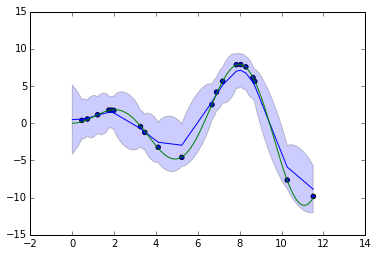

In [258]:
visual = interact(build_gp,
                  nugget=(0.0001,2.0001,0.0001),
                  lim=(0.1,1,0.1),
                  corr=('absolute_exponential',
                        'squared_exponential',
                        'generalized_exponential',
                        'cubic',
                        'linear'))